In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy import io
from mne import viz, stats
from matplotlib import colors, gridspec, offsetbox, pyplot as plt
from IPython.display import display

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.05

PROJECT_PATH = '../data' # path to where the EEG sensor position file is stored
RESULTS_PATH = '../results'
FIGURE_PATH = '../figures'
MODEL_DIR = f"new_score_rf{CAF_DOSE}" # f"new_score_rf{CAF_DOSE}" or f"logisticRegression{CAF_DOSE}"
TWO_SIDED_IMPORTANCES = False # set to true for logistic regression, false for random forest

STAGES = ['AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']
CHANNELS = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3', 'P4',
            'O1', 'O2', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']
FEATURES = ['PSD_delta', 'PSD_theta', 'PSD_alpha', 'PSD_sigma', 'PSD_beta', 'PSD_low gamma',
            'SpecShanEn', 'SampEn', 'SpecSampEn', 'PermEn', 'SpecPermEn']

delete_features = ['PSD_alpha', 'PSD_beta', 'PSD_low gamma', 'PermEn']

# Load data

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
importances = {}
scores = {}
feature_names = {}

for stage in STAGES:
    with open(os.path.join(RESULTS_PATH, MODEL_DIR, f'importances-{stage}.pickle'), 'rb') as file:
        importances[stage] = pickle.load(file)
    with open(os.path.join(RESULTS_PATH, MODEL_DIR, f'scores-{stage}.pickle'), 'rb') as file:
        scores[stage] = pickle.load(file)
    with open(os.path.join(RESULTS_PATH, MODEL_DIR, f'feature_names-{stage}.pickle'), 'rb') as file:
        feature_names[stage] = pickle.load(file)

In [5]:
importance_means = {}
importance_stds = {}
for stage in STAGES:
    importance_means[stage] = np.mean(importances[stage], axis=0)
    importance_stds[stage] = np.std(importances[stage], axis=0)

score_means = {}
score_stds = {}
for stage in STAGES:
    score_means[stage] = np.mean(scores[stage])
    score_stds[stage] = np.std(scores[stage])

# Create figures

In [6]:
feature_colors = {
    'PSD_delta': '#FF0000',
    'PSD_theta': '#FF2B00',
    'PSD_alpha': '#FF5600',
    'PSD_sigma': '#FF8100',
    'PSD_beta': '#FFAC00',
    'PSD_low gamma': '#FFD700',
    'SpecShanEn': '#00FFFF',
    'SampEn': '#00C9FF',
    'SpecSampEn': '#0099FF',
    'PermEn': '#005EFF',
    'SpecPermEn': '#0028FF'
}

## Decoding accuracy

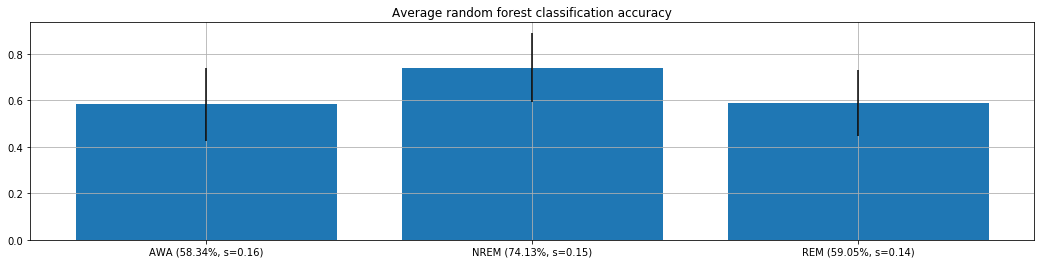

In [7]:
plt.figure(figsize=(18, 4))
plt.title('Average random forest classification accuracy')
plt.bar(np.arange(len(score_means)), score_means.values(), yerr=score_stds.values())

ticks = [stage.replace('AWSL', 'AWA') + f' ({acc*100:.2f}%, s={std:.2f})'
         for stage, acc, std in zip(STAGES, score_means.values(), score_stds.values())]
plt.xticks(np.arange(len(score_means)), ticks)
plt.grid()
plt.show()

# Feature importance bar plots
Creates bar plots for each sleep stage with color coding for different types of features. The embedded topomap shows the location of the most important feature of a particular sleep stage.

<ipython-input-8-000d1f5072f4>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(20, dtype=np.bool)
<ipython-input-8-000d1f5072f4>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(20, dtype=np.bool)
<ipython-input-8-000d1f5072f4>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence

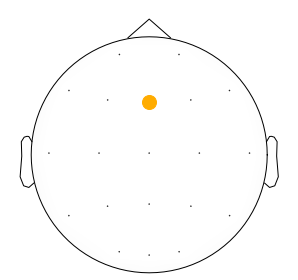

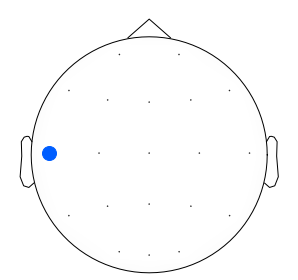

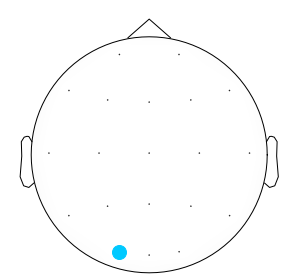

In [8]:
for stage in STAGES:
    mask = np.zeros(20, dtype=np.bool)
    mask[importance_means[stage].argmax() % 20] = True
    feat = FEATURES[int(importance_means[stage].argmax() / len(importance_means[stage]) * len(FEATURES))]
    plt.figure()
    viz.plot_topomap(np.ones(20), sensor_pos, mask=mask,
                     mask_params=dict(marker='o', markerfacecolor=feature_colors[feat],
                                      markeredgecolor=feature_colors[feat], markersize=14),
                     cmap="gray", contours=False, show=False)
    plt.tight_layout()
    plt.savefig(f"/tmp/feature_pos_{stage}.png", dpi=300, transparent=True, bbox_inches="tight", pad_inches=0)

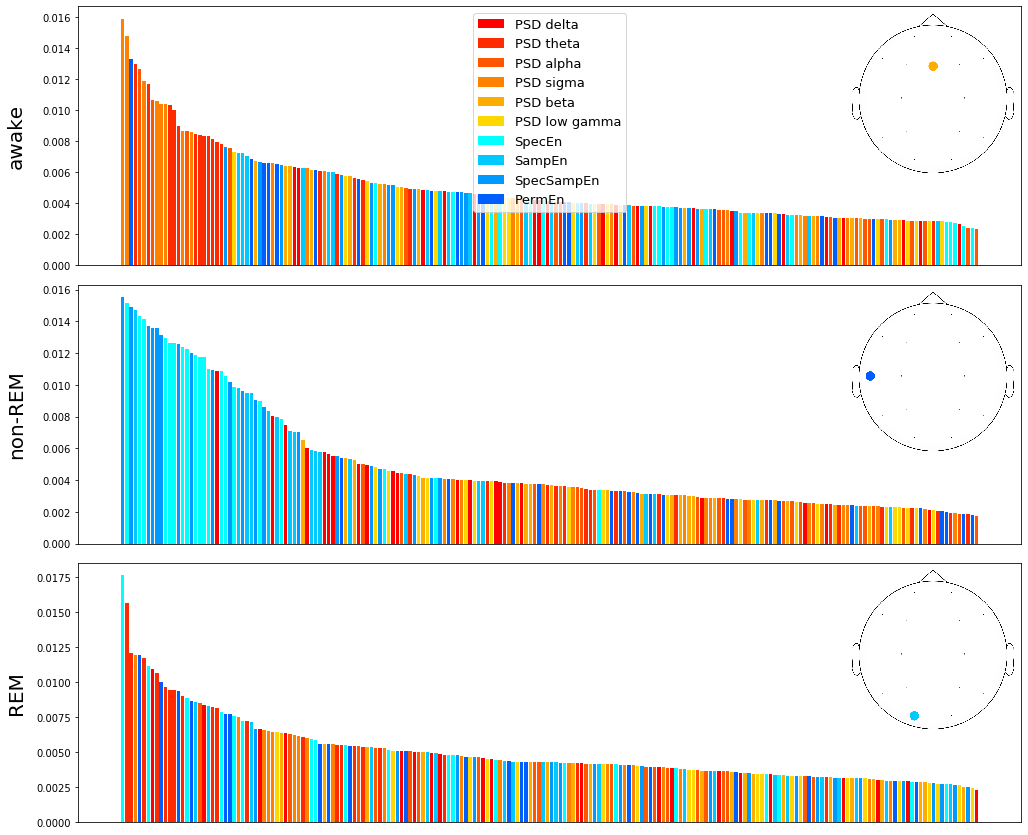

In [9]:
fontsize_big = 20
fontsize_small = 13

# create gridspec
gs = gridspec.GridSpec(len(STAGES), 2, width_ratios=[0.065, 1], wspace=0, hspace=0.075)
subplot_index = 0
plt.figure(figsize=(18, 15))

for stage in STAGES:
    # add current stage annotation
    plt.subplot(gs[subplot_index])
    subplot_index += 1
    plt.annotate(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'),
                 xy=(0, 0.5),
                 va='center',
                 ha='center',
                 fontsize=fontsize_big,
                 rotation=90)
    plt.axis('off')
    
    plt.subplot(gs[subplot_index])
    subplot_index += 1
    
    # get sorted indices for the importances
    indices = np.argsort(importance_means[stage])[::-1]
    
    # plot bars for each feature
    for category in FEATURES:
        mask = [category in name for name in feature_names[stage][indices]]
        if np.sum(mask) > 0:
            name = category.replace('_', ' ').replace('Shan', '')
            
            # plot bars of current feature
            plt.bar(np.arange(len(indices))[mask],
                    importance_means[stage][indices][mask],
                    label=name,
                    color=feature_colors[category])

    # insert topomap with location of most important feature
    imgbox = offsetbox.OffsetImage(plt.imread(f"/tmp/feature_pos_{stage}.png"), zoom=0.15)
    annotbox = offsetbox.AnnotationBbox(imgbox, (1, 1), xycoords="axes fraction",
                                        box_alignment=(1, 1), frameon=False)
    plt.gca().add_artist(annotbox)
    
    # remove x ticks
    plt.xticks([])
    # add legend
    if stage == STAGES[0]:
        plt.legend(fontsize=fontsize_small, loc="upper center")

plt.savefig(os.path.join(FIGURE_PATH, f'fig_3-rf-bars'),
            bbox_inches='tight',
            transparent=True,
            dpi=300)
plt.show()

## Top features table
Tables containing the top 10 features for each sleep stage, including the electrode name and absolute importance score.

In [10]:
#pd.options.display.float_format = '{:,.3f}'.format

for stage in STAGES:
    # find the top features with corresponding channel name
    idxs = np.argsort(importance_means[stage])[::-1][:10]
    feat = [FEATURES[int(i / len(importance_means[stage]) * len(FEATURES))] for i in idxs]
    chs = [CHANNELS[i % 20] for i in idxs]
    
    # turn data into a pandas DataFrame for nice printing
    print(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'))
    display(pd.DataFrame(columns=["feature", "electrode", "importance"],
                         data=zip([f.replace('_', ' ').replace('Shan', '') for f in feat],
                                  chs,
                                  importance_means[stage][idxs])))
    print()

awake


,feature,electrode,importance
0,PSD beta,Fz,0.015915
1,PSD beta,Cz,0.014804
2,SpecPermEn,O2,0.013341
3,PSD theta,C3,0.012981
4,PSD sigma,Oz,0.012648
5,PSD sigma,C4,0.011901
6,PSD theta,P3,0.011709
7,PSD alpha,O2,0.010681
8,PSD sigma,F4,0.010631
9,PSD sigma,C3,0.010422



non-REM


,feature,electrode,importance
0,PermEn,T3,0.015529
1,SpecEn,C4,0.015182
2,PermEn,T6,0.014926
3,SampEn,F3,0.014724
4,SampEn,Pz,0.014318
5,SampEn,P3,0.014172
6,PermEn,P4,0.013706
7,PermEn,C3,0.013576
8,SpecSampEn,F3,0.013559
9,PermEn,Cz,0.013138



REM


,feature,electrode,importance
0,SampEn,O1,0.017629
1,PSD theta,P3,0.015624
2,PSD theta,P4,0.012073
3,PSD sigma,F3,0.011943
4,SpecPermEn,Cz,0.011909
5,PSD alpha,Pz,0.011744
6,SampEn,P3,0.011175
7,PSD delta,F3,0.010907
8,PSD theta,T5,0.010612
9,SpecPermEn,F7,0.009972


## Importance distribution by features
Shows the ratios of aggregated importances of features for each sleep stage.

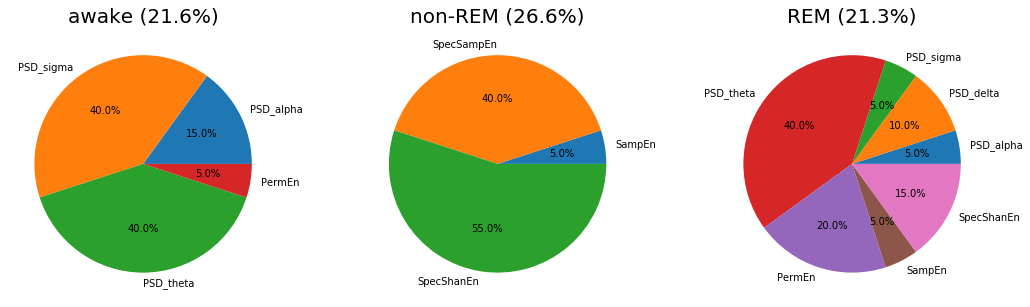

In [11]:
plt.figure(figsize=(18, 5))

for i, stage in enumerate(STAGES):
    indices = np.argsort(importance_means[stage])[::-1][:int(len(importance_means[stage])*0.1)]
    occurences = [name.split('-')[0] for name in feature_names[stage][indices]]
    shares = np.array([[feature, occurences.count(feature)] for feature in np.unique(occurences)])
    
    total = importance_means[stage][indices].sum() / importance_means[stage].sum()
    
    plt.subplot(1, 3, i + 1)
    plt.title(f'{stage.replace("AWSL", "awake").replace("NREM", "non-REM")} ({total*100:.1f}%)', fontsize=20)
    plt.pie(shares[:,1], labels=shares[:,0], autopct=lambda x: f'{x:.1f}%')
plt.show()

In [12]:
print('Maximum feature importance per sleep stage')
for stage in STAGES:
    max_value = importance_means[stage].max() / importance_means[stage].sum()
    print(f'{stage.replace("AWSL", "awake").replace("NREM", "non-REM")}: {max_value*100:.1f}%')

Maximum feature importance per sleep stage
awake: 1.6%
non-REM: 1.6%
REM: 1.8%


## Aggregated importance per feature and sleep stage
Sums feature importance across channels and shows importance distribution for each feature and sleep stage.

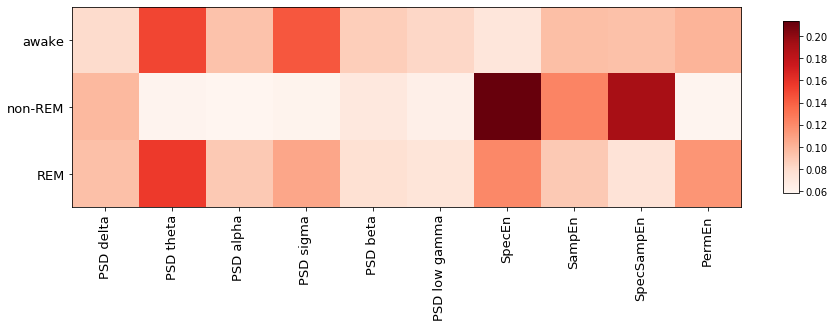

In [13]:
fontsize_small = 13
fontsize_big = 20

# get feature categories, remove duplicate elements from list while preserving order
seen = set()
seen_add = seen.add
feature_categories = [name.split('-')[0] for name in feature_names[STAGES[0]] if not (name.split('-')[0] in seen or seen_add(name.split('-')[0]))]

# sum up importance means
matrix = np.empty((len(STAGES), len(feature_categories)))
for i, stage in enumerate(STAGES):
    for j, category in enumerate(feature_categories):
        mask = [category == name.split('-')[0] for name in feature_names[stage]]
        matrix[i,j] = np.sum(importance_means[stage][mask])

# get feature names
names = []
for name in feature_categories:
    name = name.replace('_', ' ').replace('Shan', '')
    names.append(name)
        
plt.figure(figsize=(15, 6))
# plot importance matrix
plt.imshow(matrix, cmap='Reds')

# set x- and y-ticks
plt.xticks(np.arange(len(feature_categories)), names, rotation=90, fontsize=fontsize_small)
plt.yticks(np.arange(len(STAGES)),
           [stage.replace('AWSL', 'awake').replace('NREM', 'non-REM') for stage in STAGES],
           fontsize=fontsize_small)

# add colorbar
plt.colorbar(shrink=0.525, aspect=11)
plt.show()

## Feature importance topomaps
Shows full feature importance in the form of topomaps.

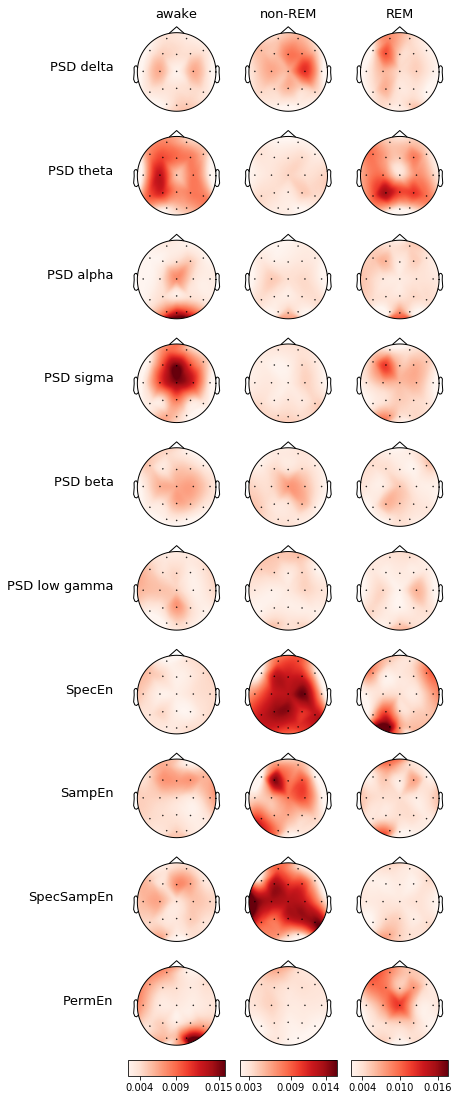

In [14]:
fontsize_small = 13
fontsize_big = 20
colormap = 'coolwarm' if TWO_SIDED_IMPORTANCES else "Reds"

# groups feature importances by feature
importance = {}
for stage in STAGES:
    mean = importance_means[stage].reshape((-1, 20))
    features = [name.split('-')[0] for name in feature_names[stage][::20]]
    importance[stage] = dict([(feature, curr) for feature, curr in zip(features, mean)])

width = len(STAGES)
height = len(importance[STAGES[0]])

# create gridspec
gs = gridspec.GridSpec(height + 2,
                       width + 1,
                       width_ratios=[0.001] + [1] * width,
                       height_ratios=[0.01] + [1] * height + [0.175])
subplot_counter = 1
plt.figure(figsize=(6, 18))

# add stage annotations
for stage in STAGES:
    plt.subplot(gs[subplot_counter])
    subplot_counter += 1
    plt.annotate(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'),
                 xy=(0.5, 0),
                 ha='center',
                 va='top',
                 fontsize=fontsize_small)
    plt.axis('off')

vmin = {}
vmax = {}
feature_labels = []
for feature in importance[STAGES[0]].keys():
    # add feature name annotations
    plt.subplot(gs[subplot_counter])
    subplot_counter += 1
    
    name = feature.replace('_', ' ').replace('SpecShanEn', 'SpecEn')
    feature_labels.append(plt.annotate(name,
                                       xy=(1, 0.5),
                                       ha='right',
                                       va='center',
                                       fontsize=fontsize_small))
    plt.axis('off')
    
    axes = []
    for stage in STAGES:
        axes.append(plt.subplot(gs[subplot_counter]))
        subplot_counter += 1
        
        # get min and max value for plots and colormaps
        vmin[stage] = np.min([np.min(importance[stage][ft]) for ft in importance[STAGES[0]].keys()])
        vmax[stage] = np.max([np.max(importance[stage][ft]) for ft in importance[STAGES[0]].keys()])
        
        if TWO_SIDED_IMPORTANCES:
            absmax = max(abs(vmin[stage]), abs(vmax[stage]))
            vmin[stage] = -absmax
            vmax[stage] = absmax
        
        # plot topomaps
        viz.plot_topomap(importance[stage][feature],
                         sensor_pos,
                         vmin=vmin[stage],
                         vmax=vmax[stage],
                         cmap=colormap,
                         contours=False,
                         show=False)

# add colorbars
subplot_counter += 1
for stage in STAGES:
    norm = colors.Normalize(vmin=vmin[stage],vmax=vmax[stage])
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=plt.subplot(gs[subplot_counter]), orientation='horizontal')
    # set colorbar ticks
    cbar.set_ticks([round(vmin[stage] + val * (vmax[stage] - vmin[stage]), 3) for val in [0.1, 0.5, 0.9]])
    subplot_counter += 1
    
plt.savefig(os.path.join(FIGURE_PATH, f'fig_4-rf-topo'),
            bbox_inches='tight',
            bbox_extra_artists=feature_labels,
            transparent=True,
            dpi=300)
plt.show()